# Inspect Reference Anndata

Date: 14May2024

Author: Jrose

In this notebook I am going to quickly inspect the reference atlas AnnData objects created from the PrepBigRef notebook.

Ultimatley I am looking to decide how best to select highly variable genes (HVG) to optimize the scvi/scANVI training processes

## SLE-only Atlas 

Let's start with the disease cell only atlas. This contains only B cells or PB from SLE patients.

In [1]:
import scanpy as sc
import os
import scvi
import torch

data_dir="/home/Projects/Scharer_sc/scAtlas_ref/analysis/ref_objs"
SLE_file="BcellRefAtlas_SLE.h5ad"

scvi.settings.seed = 1990

SLE_adata_path = os.path.join(data_dir, SLE_file)

SLE_adata = sc.read_h5ad(SLE_adata_path)
SLE_adata

/home/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 1990


AnnData object with n_obs × n_vars = 106005 × 15123
    obs: 'batch', 'indiv', 'ancestry', 'disease_status', 'age', 'coarse_lbl', 'fine_lbl', 'disease_state', 'sex', 'study', 'labels'
    layers: 'counts'

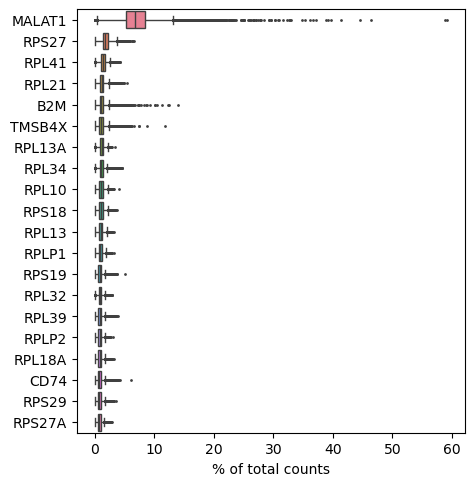

In [2]:
sc.pl.highest_expr_genes(SLE_adata, n_top=20)

In [3]:
SLE_adata.var['mt'] = SLE_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(SLE_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

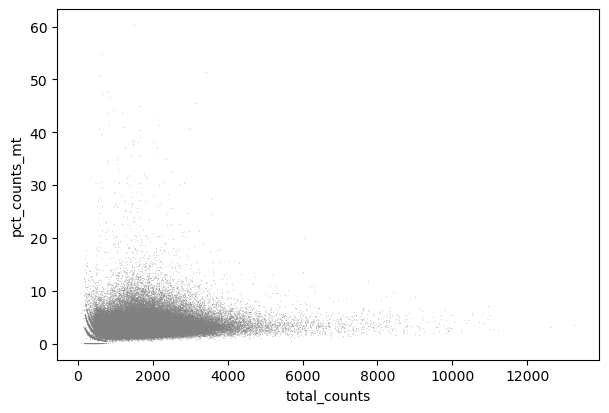

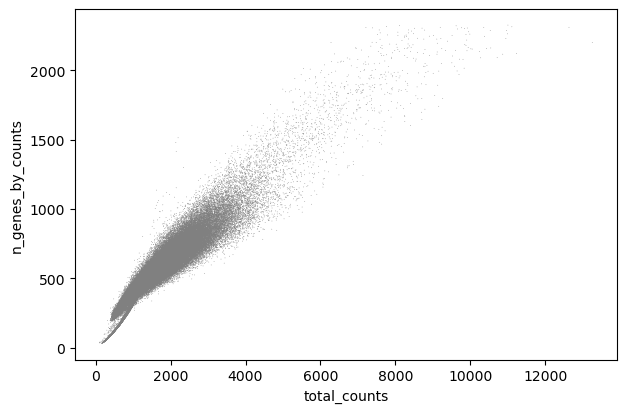

In [4]:
sc.pl.scatter(SLE_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(SLE_adata, x='total_counts', y='n_genes_by_counts')

In [6]:
SLE_adata.layers["counts"] = SLE_adata.X.copy()
sc.pp.normalize_total(SLE_adata, target_sum=1e4)
sc.pp.log1p(SLE_adata)

In [19]:
SLE_adata.raw = SLE_adata
sc.pp.highly_variable_genes(SLE_adata,
                            min_mean=0.0125,
                            max_mean=50,
                            min_disp=0.25,
                            subset=False,
                            batch_key="batch"
                           )

/home/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to 

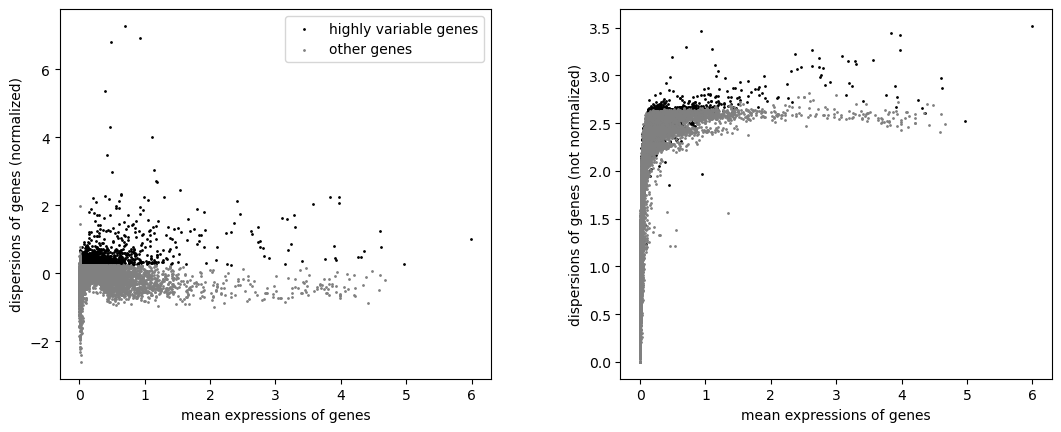

In [20]:
sc.pl.highly_variable_genes(SLE_adata)

In [21]:
SLE_adata

AnnData object with n_obs × n_vars = 106005 × 15123
    obs: 'batch', 'indiv', 'ancestry', 'disease_status', 'age', 'coarse_lbl', 'fine_lbl', 'disease_state', 'sex', 'study', 'labels', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [22]:
SLE_adata.var['highly_variable'].sum()

2133

It seems like the parameters I've ended on here get me a roboust (~2000) HVG list. 

### Let's do a quick UMAP 

In [ ]:
SLE_adata = SLE_adata[:, SLE_adata.var['highly_variable']].copy()

In [24]:
sc.tl.pca(SLE_adata)
sc.pp.neighbors(SLE_adata, n_neighbors=10, n_pcs=30)
#sc.tl.paga(SLE_adata)
#sc.pl.paga(SLE_adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(SLE_adata)

/home/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_m

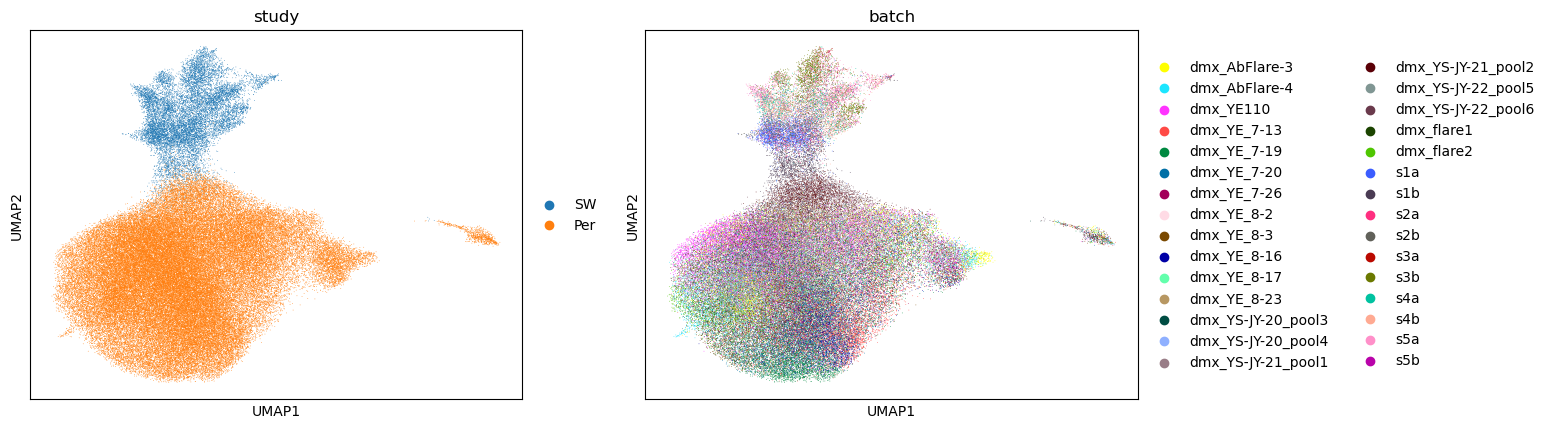

In [29]:
sc.pl.umap(SLE_adata, color=['study','batch'])

Definitley some batch effect here. Hopefully the scvi models can help with that!

## HC Only Reference

Now let's repeat these steps with the HC reference

In [30]:
HC_file="BcellRefAtlas_HC.h5ad"
HC_adata_path = os.path.join(data_dir, HC_file)

HC_adata = sc.read_h5ad(HC_adata_path)
HC_adata

AnnData object with n_obs × n_vars = 69176 × 15123
    obs: 'batch', 'indiv', 'ancestry', 'disease_status', 'age', 'coarse_lbl', 'fine_lbl', 'disease_state', 'sex', 'study', 'labels'
    layers: 'counts'

In [31]:
HC_adata.layers["counts"] = HC_adata.X.copy()
sc.pp.normalize_total(HC_adata, target_sum=1e4)
sc.pp.log1p(HC_adata)

In [32]:
HC_adata.raw = HC_adata
sc.pp.highly_variable_genes(HC_adata,
                            min_mean=0.0125,
                            max_mean=50,
                            min_disp=0.25,
                            subset=False,
                            batch_key="batch"
                           )

/home/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to 

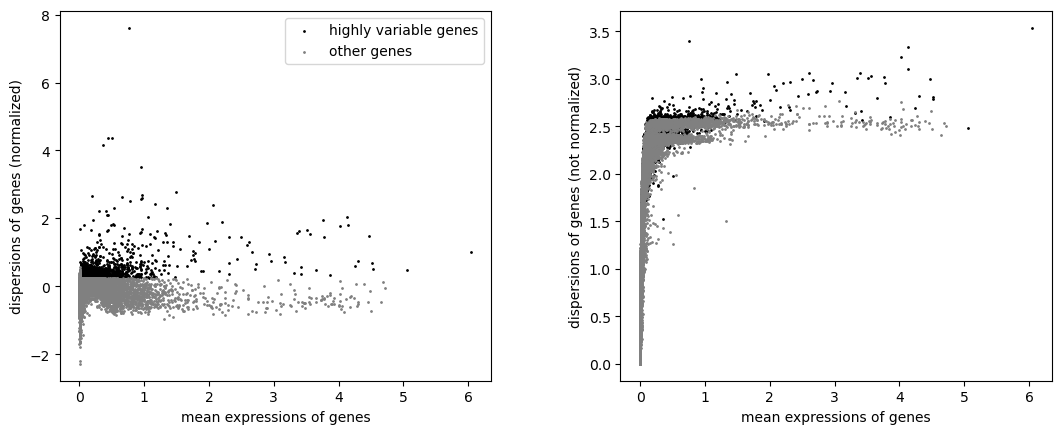

In [33]:
sc.pl.highly_variable_genes(HC_adata)

In [34]:
HC_adata.var['highly_variable'].sum()

1987

Also pretty good. I think I'll keep these settings for the final preprocessing